# Prepare Ross Ice Shelf gravity data

import the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, utils, maps
import pygmt
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
import harmonica as hm
import pooch
from pyproj import Transformer
import os
os.getcwd()

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


'c:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_gravity_inversion'

# ROSETTA-Ice data

## load data
with antarctic_plots.fetch

                Line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height              x             y  FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  3.982790e+05  
mean      793.056619  -84278.810943 -1.000705e+06  4.329633e-15  
std        83.977581  212966.781186  1.984653e+05  1.425479e+01  
min       650.023000 -571781.809097 -1.367767e+06 -2.854953e+02  
25%       744.524000 -240585.860838 -1.160510e+06 -7.3644

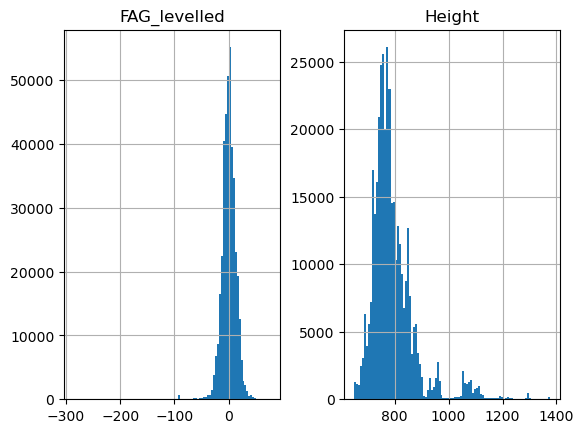

In [2]:
rosetta = fetch.ROSETTA_gravity()

rosetta[['FAG_levelled','Height']].hist(bins=100)
print(rosetta.describe())

In [3]:
# seperate e-w flight lines from n-s tie lines
ties=rosetta[rosetta.Line>=1000]
lines=rosetta[rosetta.Line<1000]

In [4]:
def plot_flightlines(
    fig: pygmt.Figure, 
    df: pd.DataFrame, 
    direction: str = 'EW',
    plot_labels: bool = True,
    plot_lines: bool =True,
    **kwargs
    ):

    # group lines by their line number
    lines = [v for _, v in df.groupby('Line')]

    # plot lines
    if plot_lines is True:
        for i in list(range(len(lines))): 
            fig.plot(
                x=lines[i].x, 
                y=lines[i].y, 
                pen=kwargs.get("pen", '0.3p,white'),
                ) 

    # plot labels
    if plot_labels is True: 
        for i in list(range(len(lines))): 
            # switch label locations for every other line          
            if (i%2) == 0:
                if direction == 'EW':
                    offset='0.25c/0c'
                    # plot label at max value of x-coord
                    x_or_y='x'
                    # angle of label
                    angle=0
                elif direction == 'NS':
                    offset='0c/0.25c'
                    # plot label at max value of y-coord
                    x_or_y='y'
                    # angle of label
                    angle=90
                else: 
                    raise ValueError("invalid direction string")
                # plot label
                fig.text(
                    x=lines[i].x.loc[lines[i][x_or_y].idxmax()], 
                    y=lines[i].y.loc[lines[i][x_or_y].idxmax()], 
                    text=str(lines[i].Line.iloc[0]), 
                    justify='CM', 
                    font=kwargs.get("font", '5p,black'), 
                    fill='white', 
                    offset=offset,
                    angle=angle,
                    )
            else:
                if direction == 'EW':
                    offset='-0.25c/0c'
                    # plot label at max value of x-coord
                    x_or_y='x'
                    # angle of label
                    angle=0
                elif direction == 'NS':
                    offset='0c/-0.25c'
                    # plot label at max value of y-coord
                    x_or_y='y'
                    # angle of label
                    angle=90
                else: 
                    raise ValueError("invalid direction string")
                # plot label
                fig.text(
                    x=lines[i].x.loc[lines[i][x_or_y].idxmin()], 
                    y=lines[i].y.loc[lines[i][x_or_y].idxmin()], 
                    text=str(lines[i].Line.iloc[0]), 
                    justify='CM', 
                    font=kwargs.get("font", '5p,black'), 
                    fill='white', 
                    offset=offset,
                    angle=angle,
                    )

Plot as point data

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


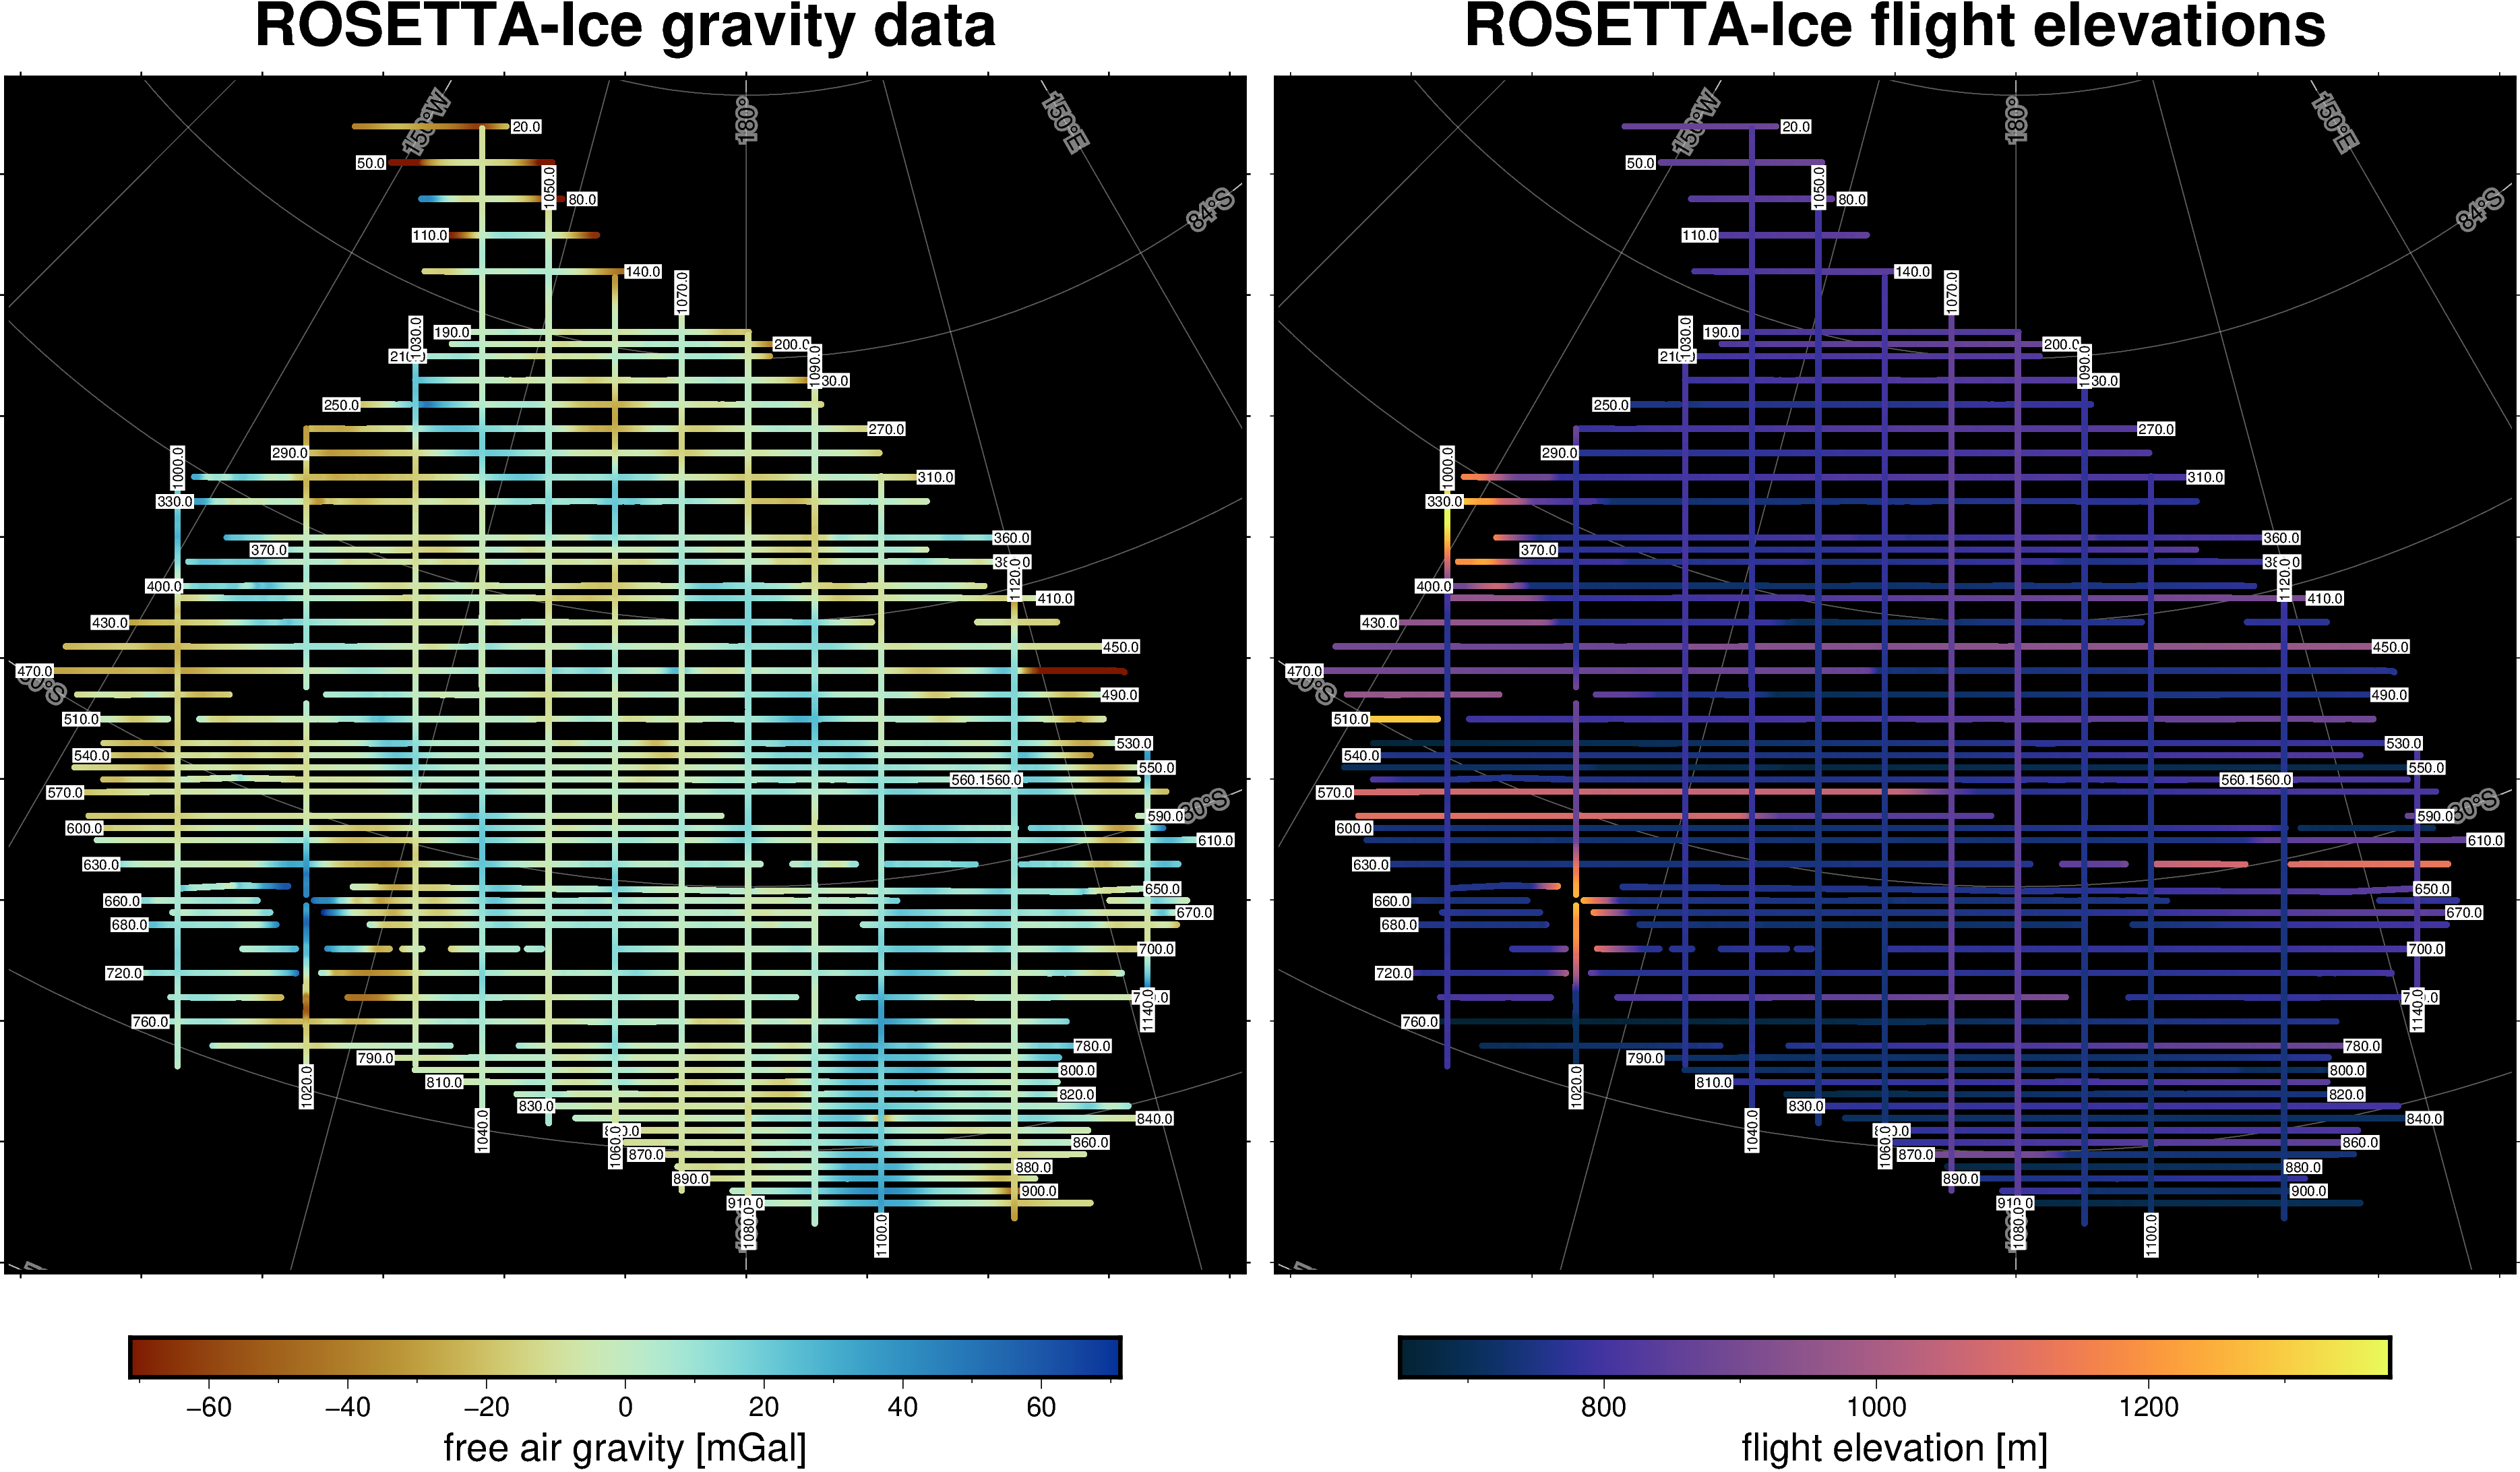

In [6]:
# get bounding region of data
region = vd.get_region((rosetta.x, rosetta.y))
# zoom out by 20 km
region = utils.alter_region(region, zoom=-40e3)[0]

# plot a basemap
fig = maps.basemap(
    region, 
    title="ROSETTA-Ice gravity data",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(rosetta.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=rosetta.x, 
         y=rosetta.y, 
         color=rosetta.FAG_levelled,
         style='c2p',
         cmap=True)

plot_flightlines(fig, lines, plot_lines=False, direction='EW')
plot_flightlines(fig, ties, plot_lines=False, direction='NS')

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="ROSETTA-Ice flight elevations",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# make a colorscale for flight elevations 
pygmt.makecpt(cmap="thermal", series=[rosetta.Height.min(), rosetta.Height.max()])

# plot flight elevation data
fig.plot(x=rosetta.x, 
         y=rosetta.y, 
         color=rosetta.Height,
         style='c2p',
         cmap=True)

plot_flightlines(fig, lines, plot_lines=False, direction='EW')
plot_flightlines(fig, ties, plot_lines=False, direction='NS')

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

Plot as a grid to compare to later

blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values
blockmedian [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmedian [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
blockmedian (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps|

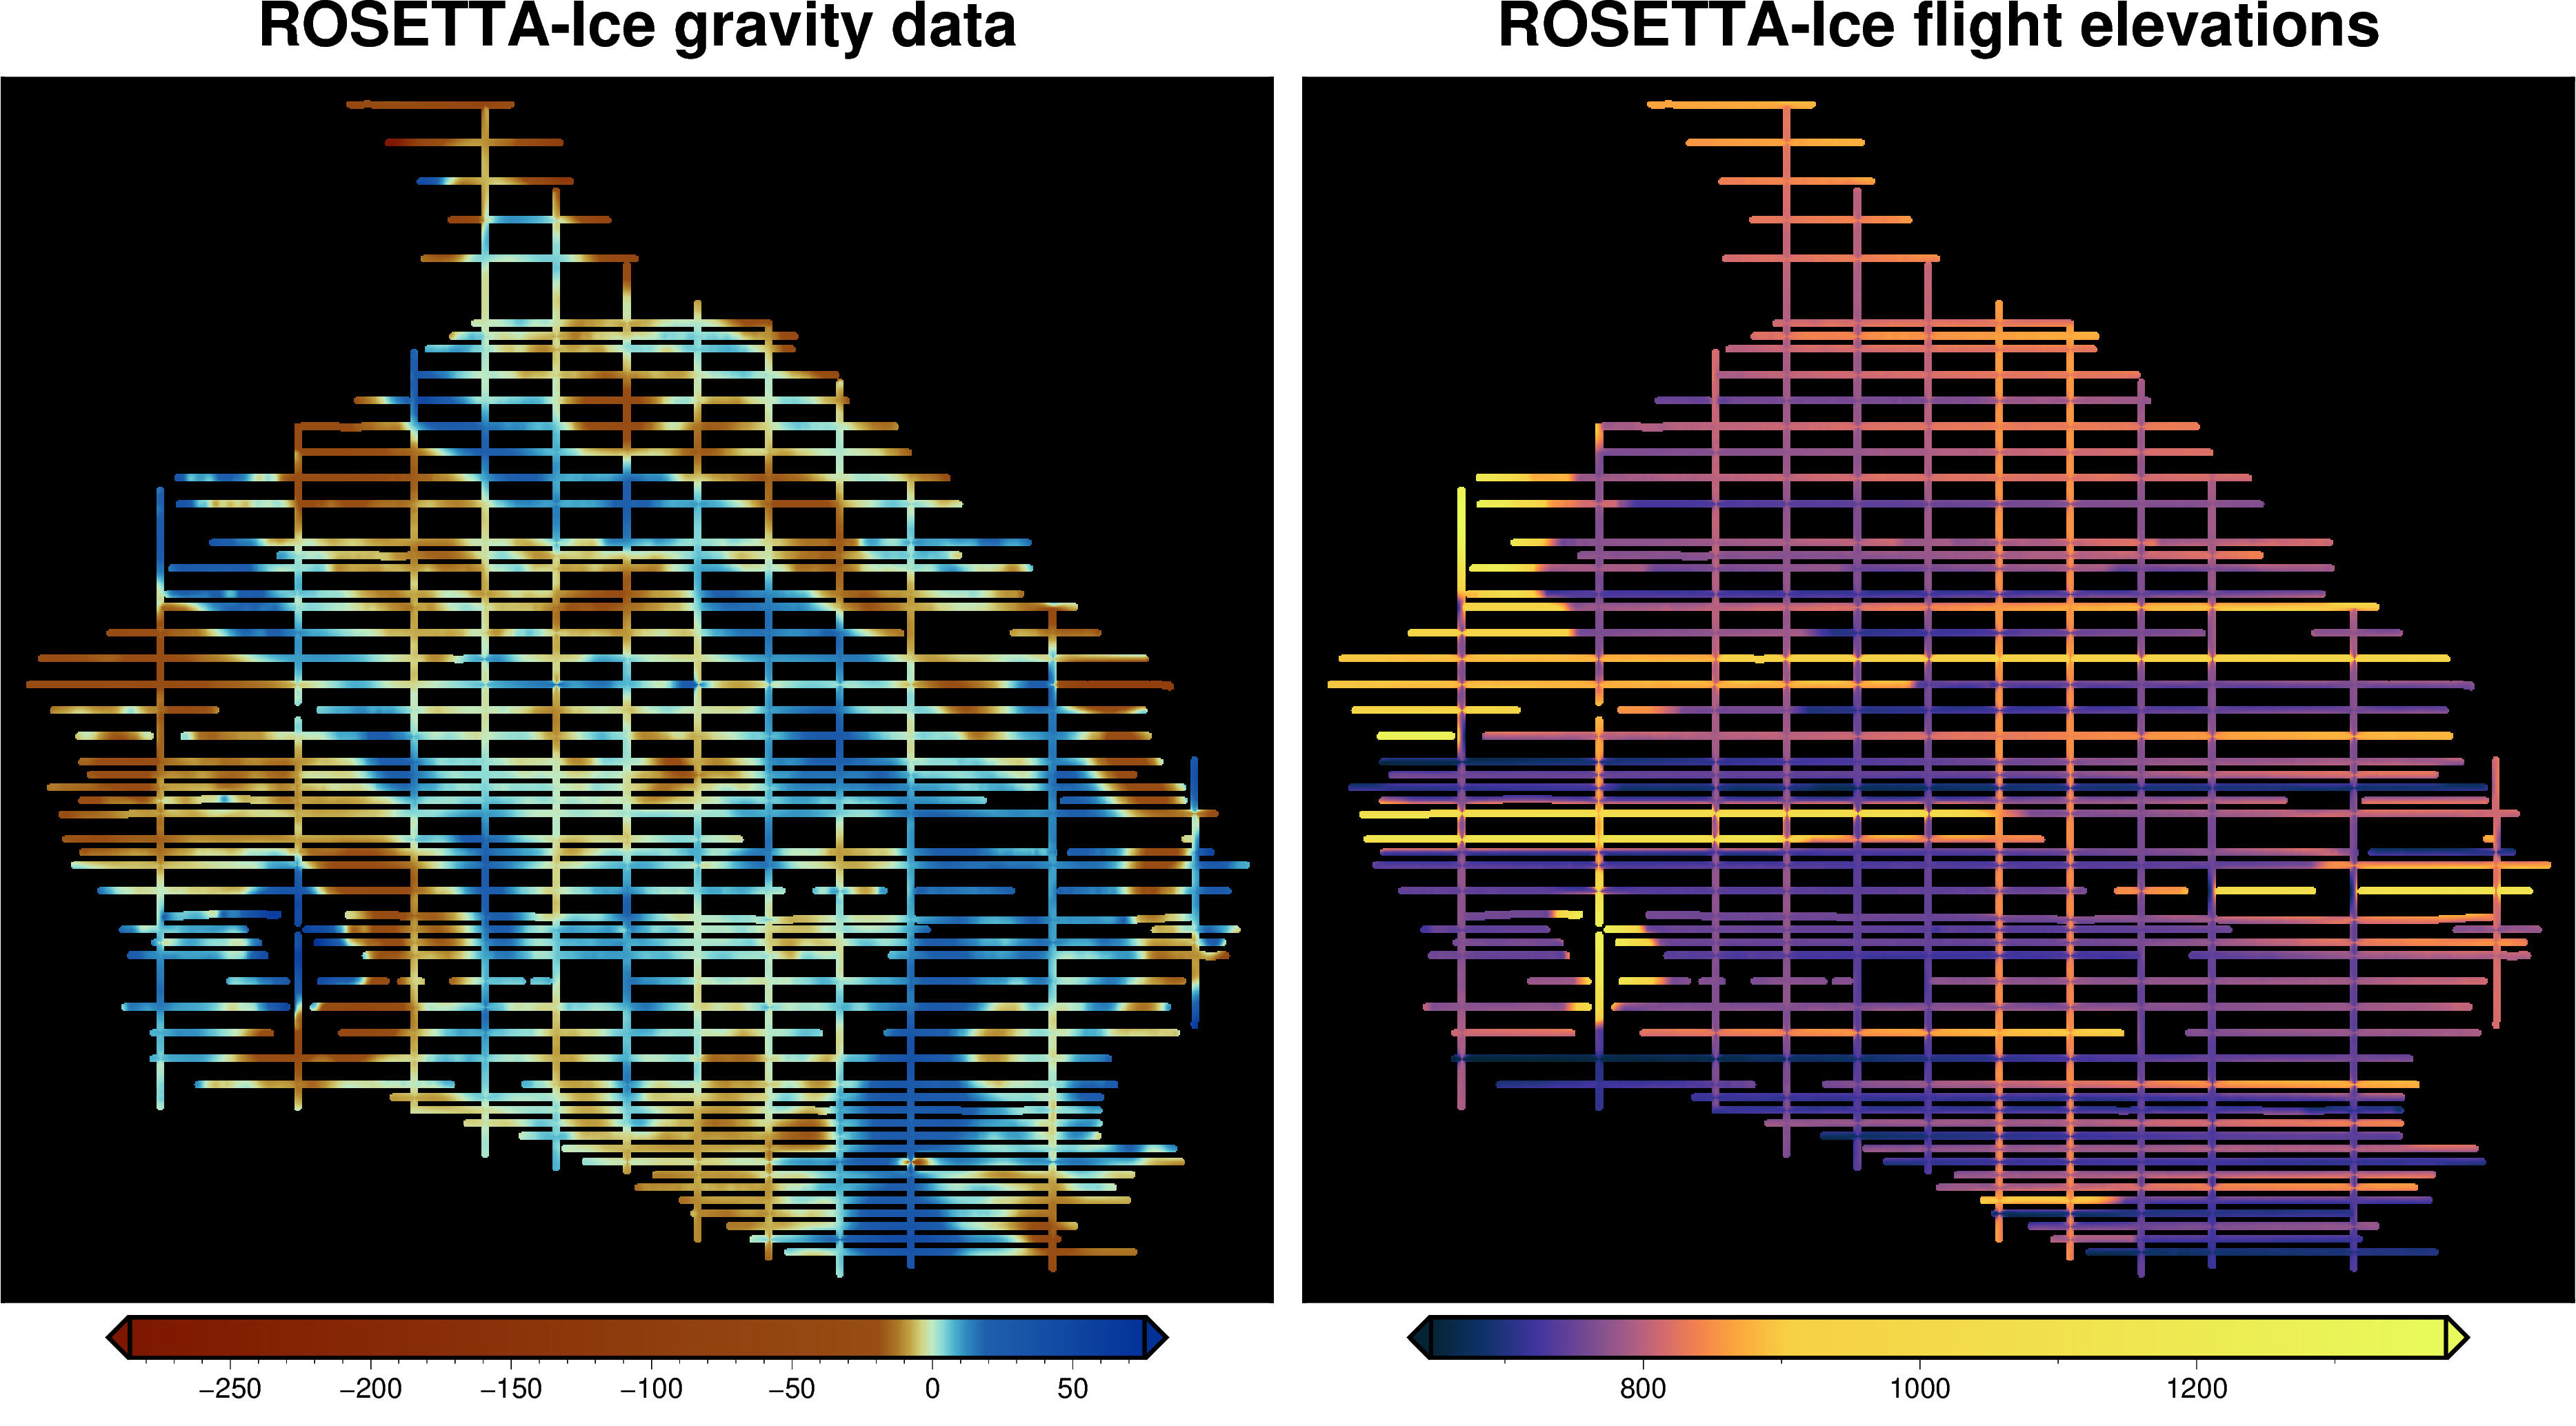

In [8]:
# block the grav data
rosetta_block = pygmt.blockmedian(
    data=rosetta[["x", "y", "FAG_levelled"]], 
    spacing="1000", 
    region=region,
    )
# block the elevation data
rosetta_block_height = pygmt.blockmedian(
    data=rosetta[["x", "y", "Height"]], 
    spacing="1000", 
    region=region,
    )

# grid the blocked grav data
rosetta_grav_grid = pygmt.surface(
    data=rosetta_block,
    spacing='1000', 
    M='2c', 
    registration='p',
    region=region,
    ) 

# grid the blocked elevation data
rosetta_elev_grid = pygmt.surface(
    data=rosetta_block_height,
    spacing='1000', 
    M='2c', 
    registration='p',
    region=region,
    ) 

# plot the grids
fig = maps.plot_grd(
    rosetta_grav_grid,
    cmap="roma",
    grd2cpt=True,
    title="ROSETTA-Ice gravity data",
    background='black',
)

fig = maps.plot_grd(
    rosetta_elev_grid,
    cmap="thermal",
    grd2cpt=True,
    title="ROSETTA-Ice flight elevations",
    background='black',
    fig=fig,
    origin_shift='xshift',
)
fig.show()

## Block reduce

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


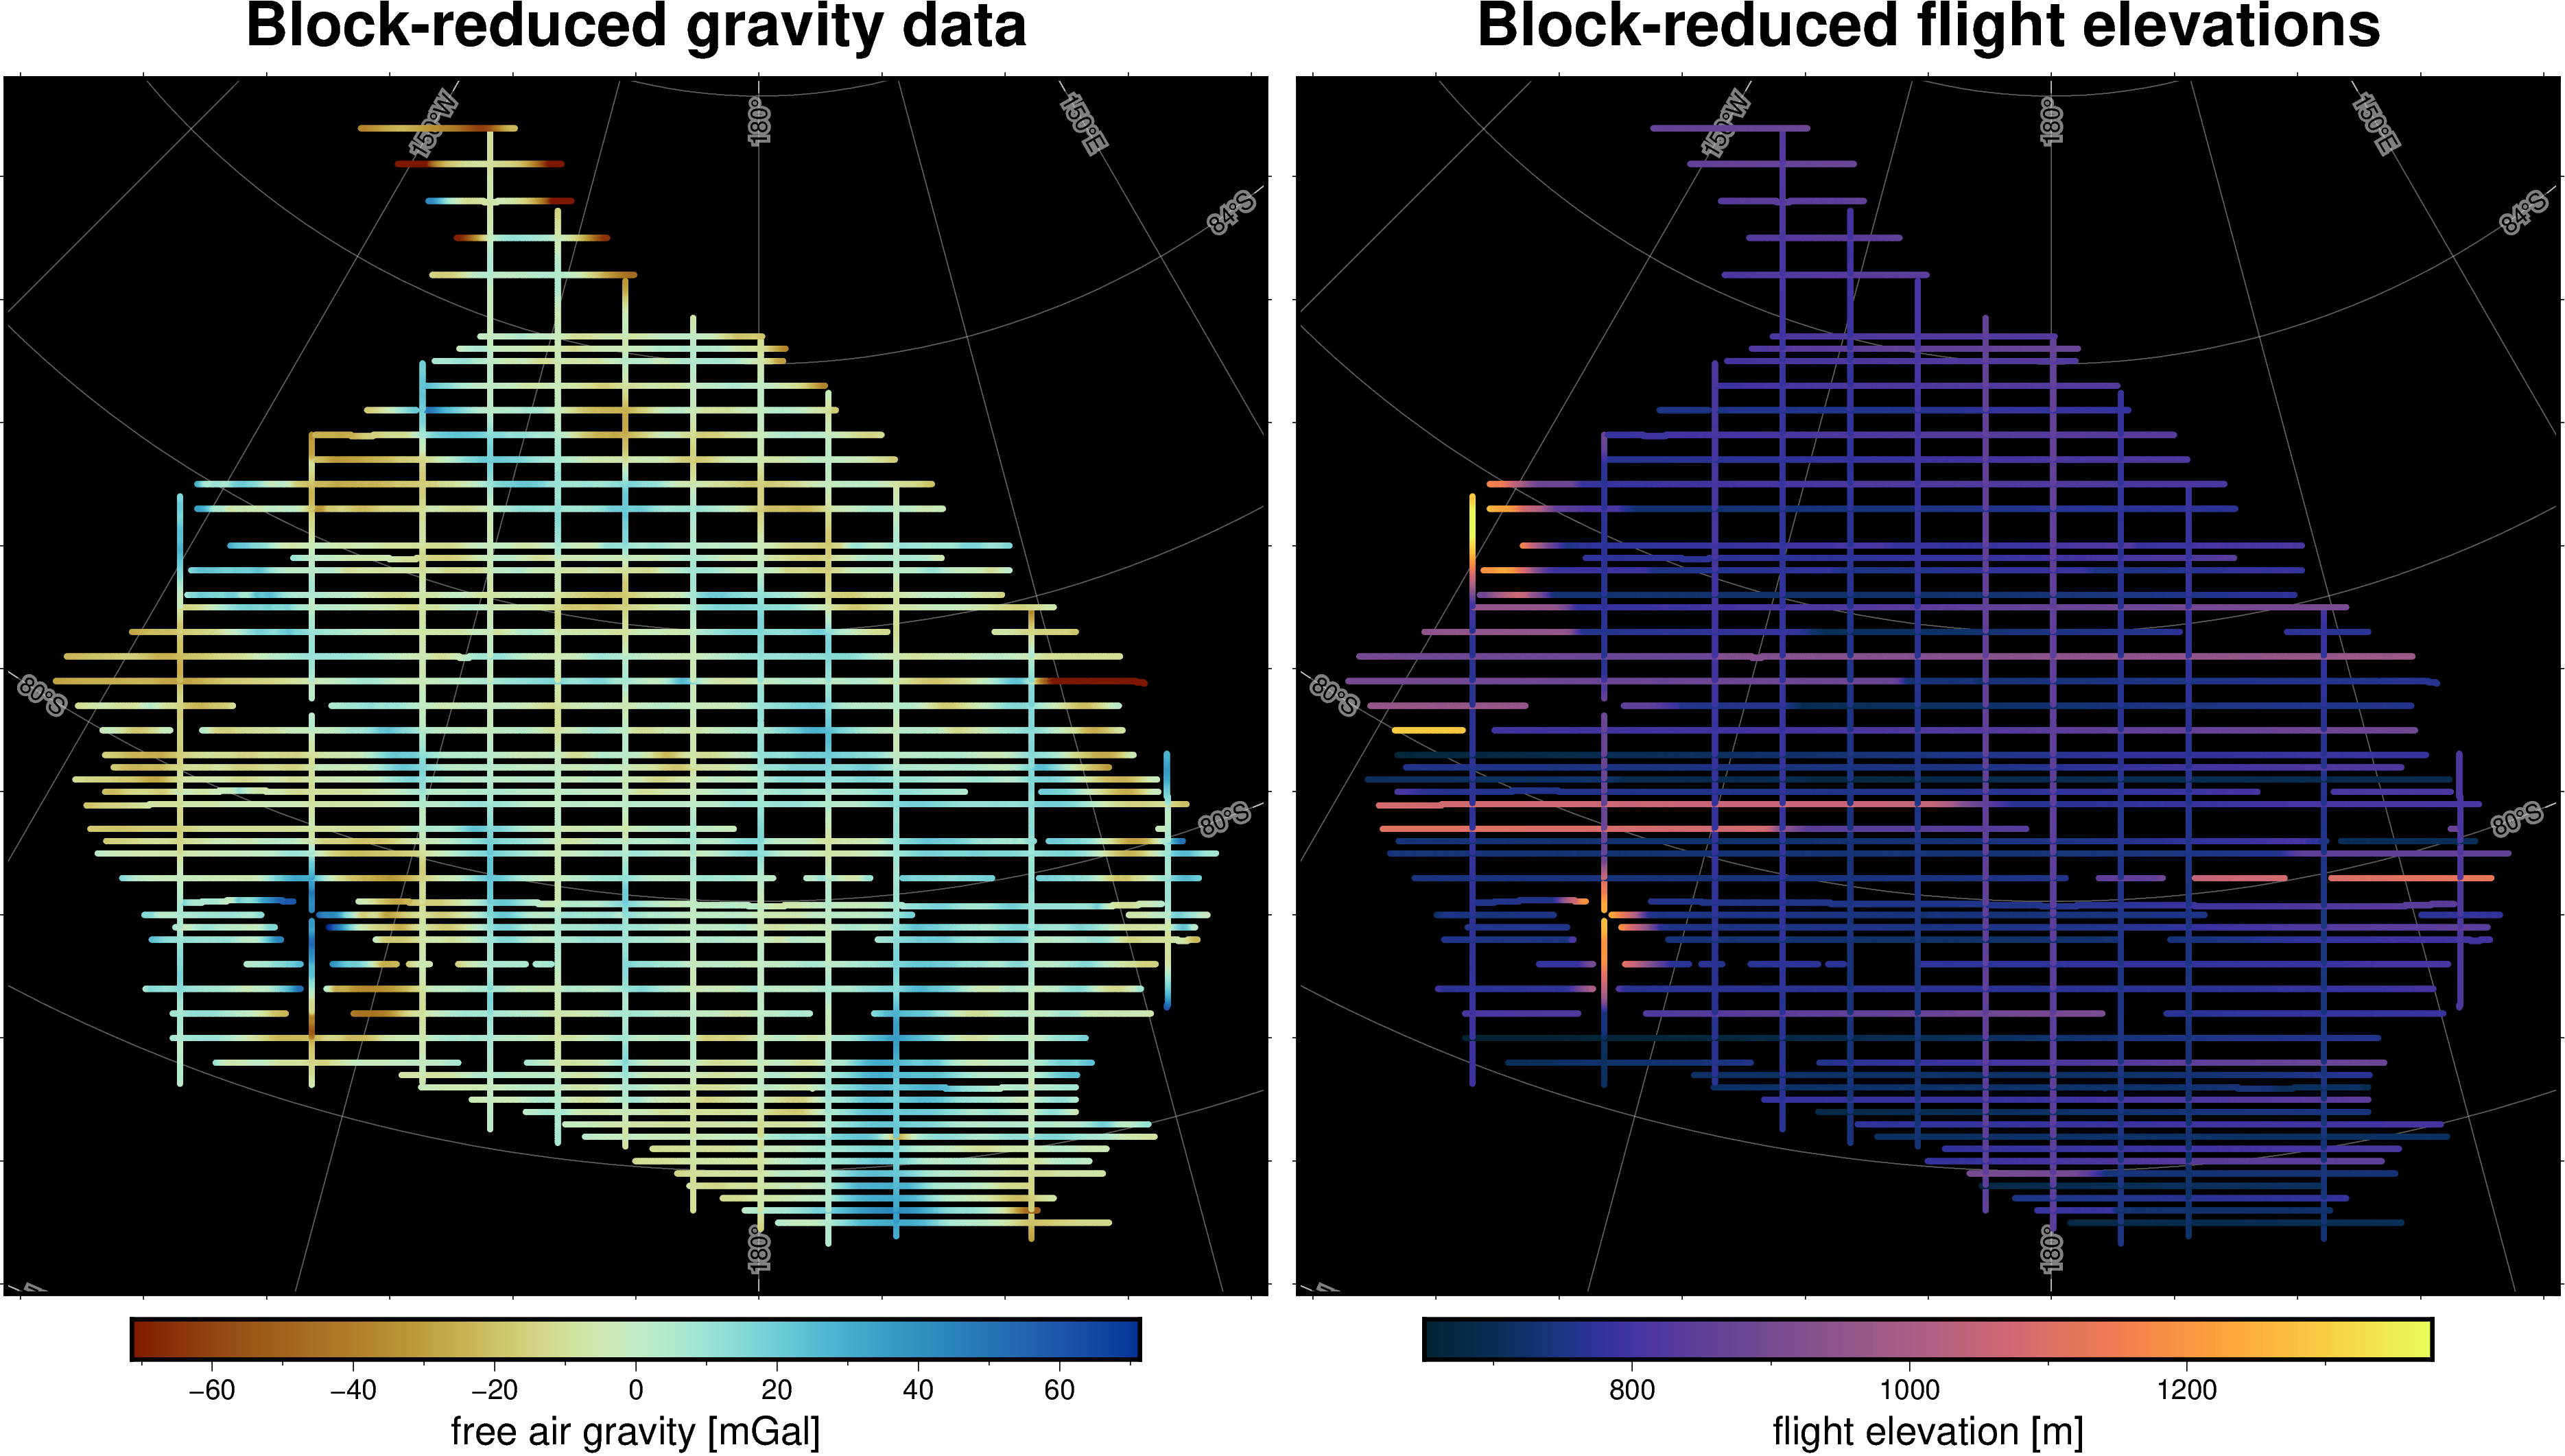

In [33]:
# set up parameters for a block reduction
reducer = vd.BlockReduce(
    # reduction=np.mean, 
    reduction=np.median, 
    spacing=1e3, 
    center_coordinates=True, # get average coordinate, not the center
    )

# get the mean/median gravity anomaly and flight elevation within each block
coordinates, data = reducer.filter(
    coordinates=(rosetta.x, rosetta.y), data=(rosetta.FAG_levelled, rosetta.Height))
# put results into dataframe
df = pd.DataFrame(data={'x': coordinates[0], 'y':coordinates[1], 'FAG_levelled':data[0], 'elev':data[1]})

# plot a basemap
fig = maps.basemap(
    region, 
    title="Block-reduced gravity data",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FAG_levelled,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="Block-reduced flight elevations",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# make a colorscale for flight elevations 
pygmt.makecpt(cmap="thermal", series=[df.elev.min(), df.elev.max()])

# plot flight elevation data
fig.plot(x=df.x, 
         y=df.y, 
         color=df.elev,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

## create equivalent sources

In [34]:
coordinates = (df.x, df.y, df.elev) 
eqs_first_guess = hm.EquivalentSources(
    depth=10e3, 
    block=5e3,
    # depth_type='constant', # make the depths constant, not relative to obs elev. # not conclusive for which is best in Soler and Uieda 2021
    damping=10) # high makes smoother predictions, lower can overfit / produce artifacts
eqs_first_guess.fit(coordinates, df.FAG_levelled)

In [8]:
df['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  
count              7157.000000  
mean                  0.000070  
std                  12.498866  
min                 -69.597653  
25%                  -7.600618  
50%                  -0.027042  
75%                   7.618331  
max                  66.708382

In [9]:
score_first_guess = np.mean(
    vd.cross_val_score(
        eqs_first_guess,
        coordinates,
        df_cleaned.FAG_levelled,
    )
)
score_first_guess

0.9690121408449187

In [10]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]


In [11]:
equivalent_sources = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    equivalent_sources.set_params(**params)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            df_cleaned.FAG_levelled,
        )
    )
    scores.append(score)
scores

[0.9640483647824709,
 0.9724201635994392,
 0.9739273880357218,
 0.9310816708777274,
 0.9640386321997385,
 0.9734499605353749,
 0.9705197892135453,
 0.913960930968787,
 0.9639434896805408,
 0.9735816138649689,
 0.9613793790732073,
 0.8919433164568862,
 0.9630524625549899,
 0.9690121408449187,
 0.9444058437731723,
 0.8545004511290024]

In [12]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Score with defaults:", score_first_guess)
print("Best parameters:", parameter_sets[best])

Best score: 0.9739273880357218
Score with defaults: 0.9690121408449187
Best parameters: {'damping': 0.01, 'depth': 20000.0}


In [13]:
eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, df_cleaned.FAG_levelled
)

In [14]:
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3, # upward continue to 1km
)

grid_first_guess = eqs_first_guess.grid(grid_coords)
grid = eqs_best.grid(grid_coords)

# Predict values at obs points
df_cleaned['best_disturbance'] = eqs_best.predict(coordinates)
df_cleaned['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df_cleaned.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  best_disturbance  
count              7157.000000       7157.000000  
mean                  0.000070          0.000003  
std                  12.498866         12.539680  
min                 -69.597653        -71.967084  
25%                  -7.600618         -7.612527  
50%                  -0.027042         -0.041672  
75%                   7.618331          7.633021  
max                  66.708382         69.517281

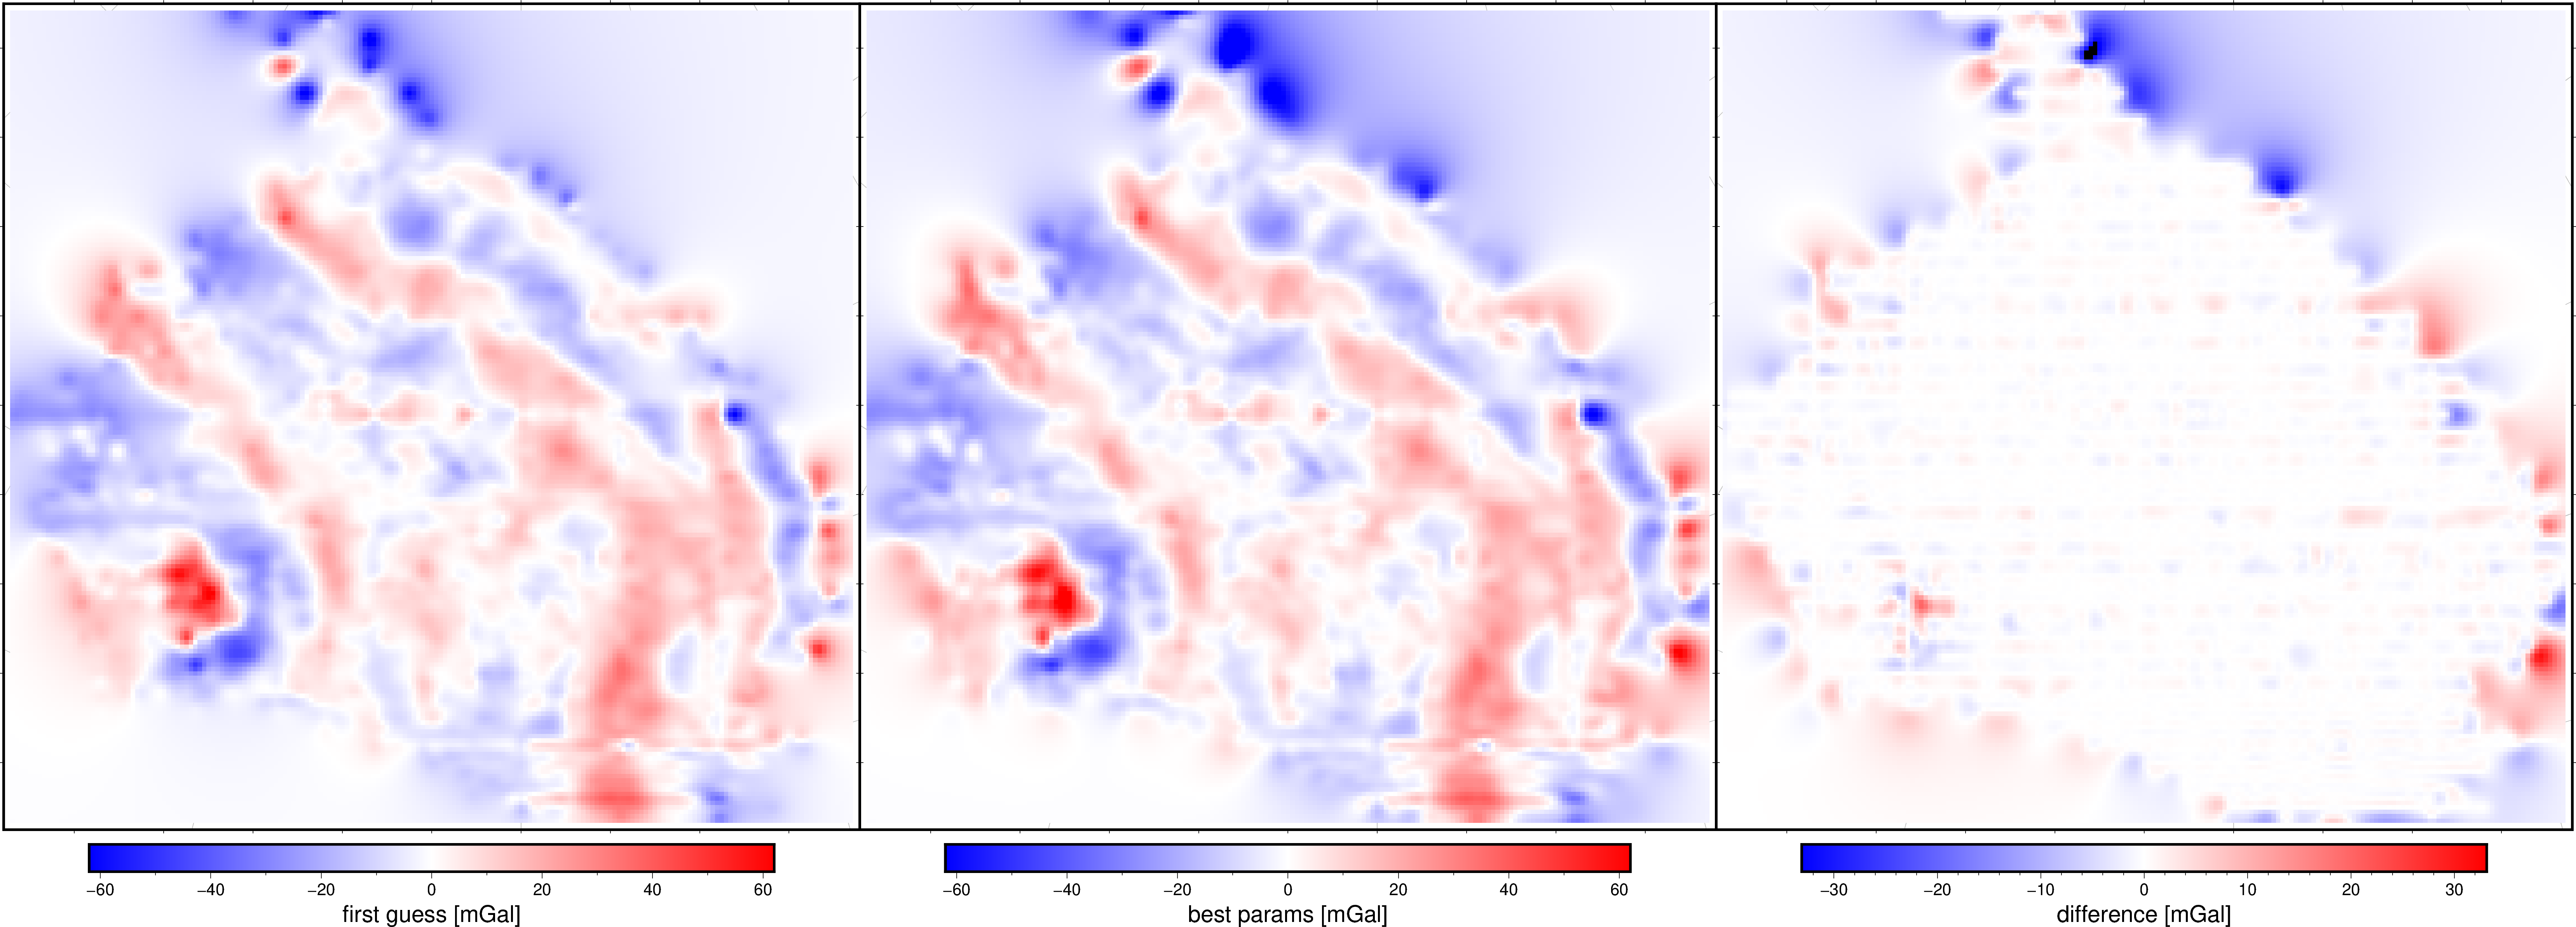

In [15]:
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y))
maxabs = vd.maxabs(grid_first_guess.scalars)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs], background=True)  
fig.grdimage(grid=grid_first_guess.scalars, cmap=True)
fig.colorbar(frame='af+l"first guess [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
fig.grdimage(grid=grid.scalars, cmap=True)
fig.colorbar(frame='af+l"best params [mGal]"')

dif = grid.scalars - grid_first_guess.scalars
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
maxabs = vd.maxabs(dif)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
fig.grdimage(grid=dif, cmap=True)
fig.colorbar(frame='af+l"difference [mGal]"')

fig.show()

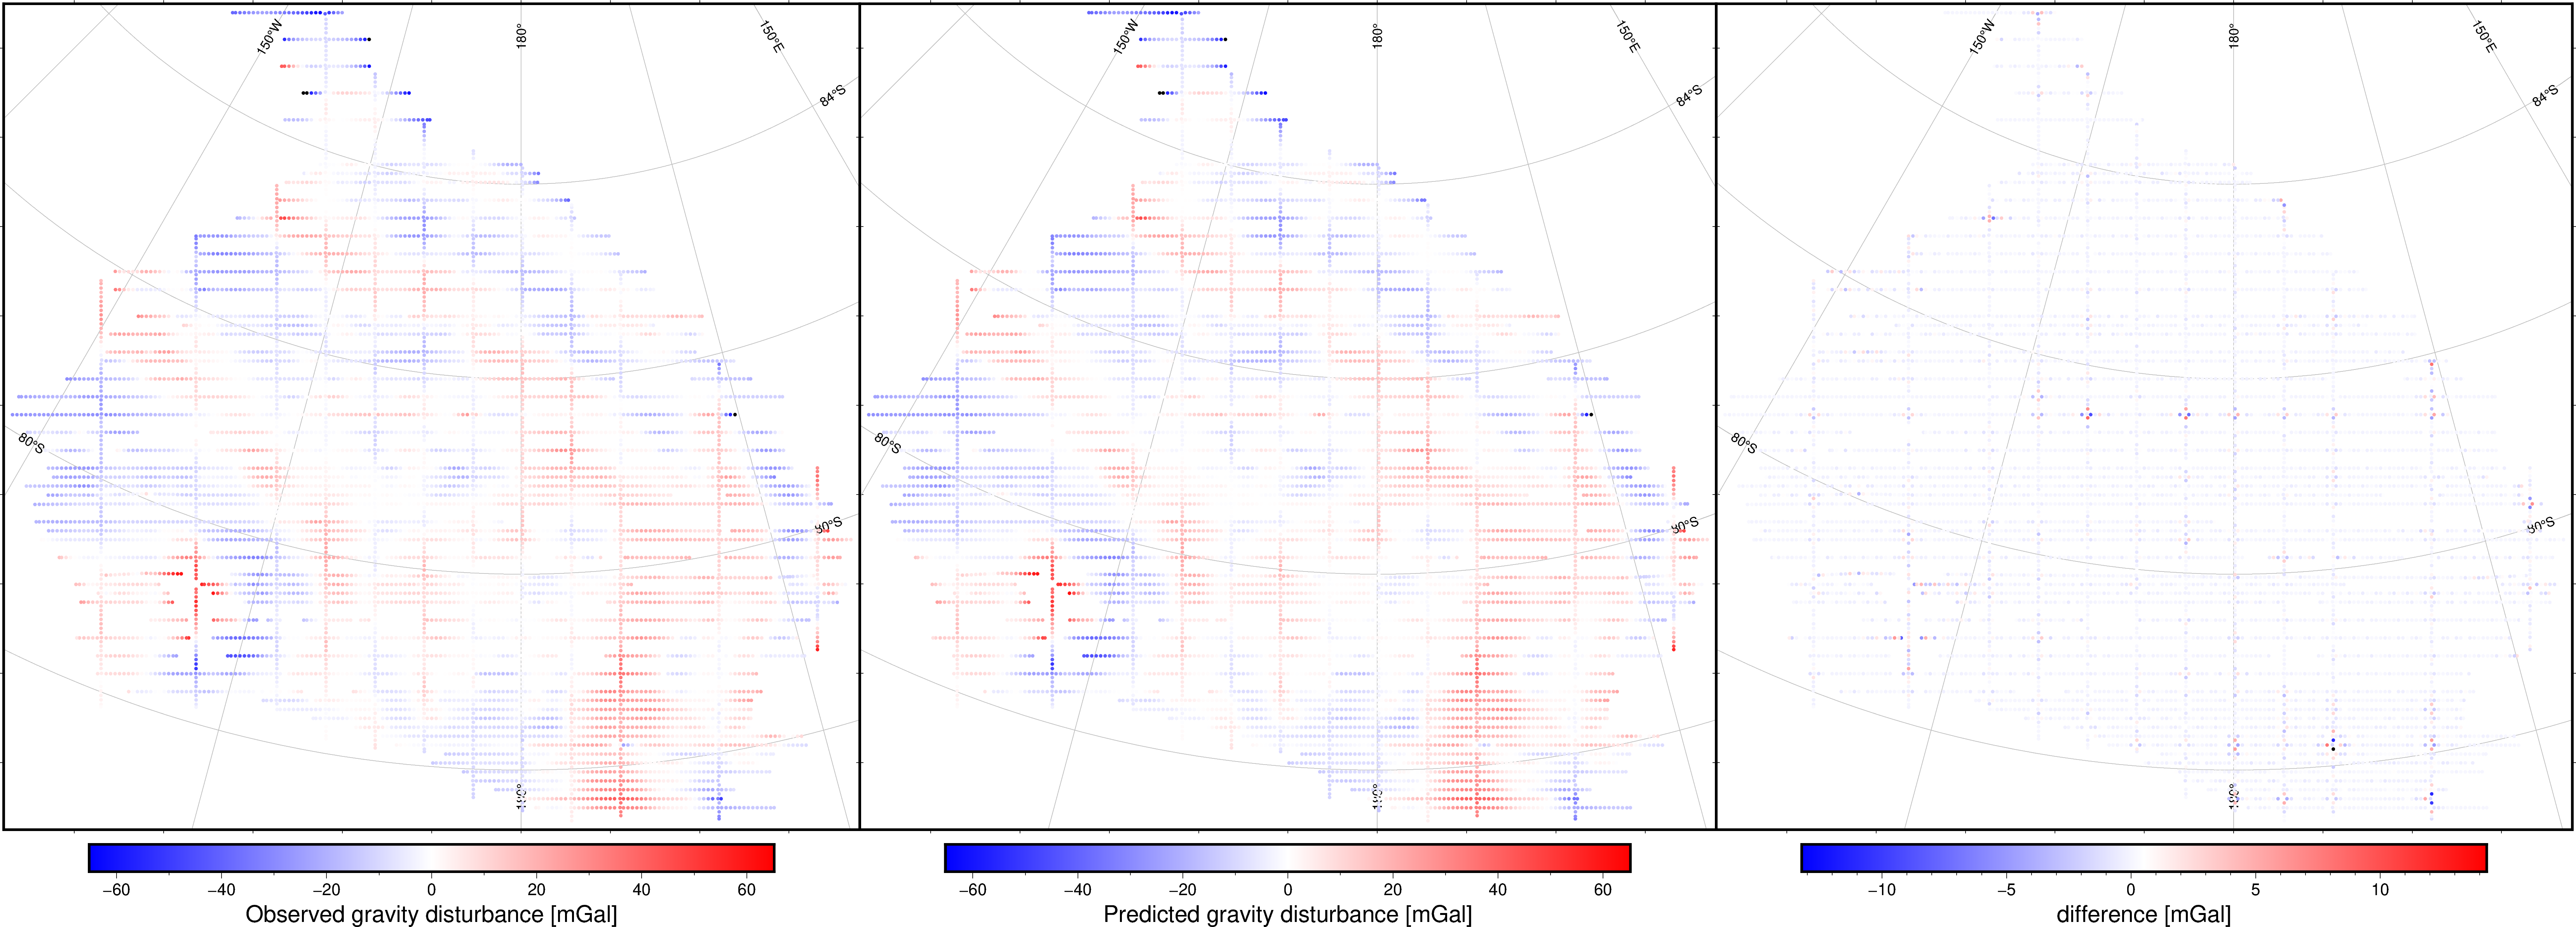

<AxesSubplot:>

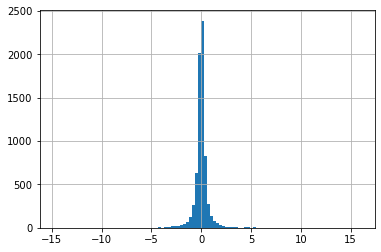

In [16]:
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y))
maxabs = vd.maxabs(df_cleaned.FAG_levelled)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c2p',
         cmap=True)
fig.colorbar(frame='af+l"Observed gravity disturbance [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.best_disturbance,
         style='c2p', 
         cmap=True)
fig.colorbar(frame='af+l"Predicted gravity disturbance [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
dif = df_cleaned.best_disturbance-df_cleaned.FAG_levelled
pygmt.makecpt(cmap="polar", series=[dif.min()*.9,dif.max()*.9])  
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=dif,
         style='c2p', 
         cmap=True)
fig.colorbar(frame='af+l"difference [mGal]"')

fig.show()
dif.hist(bins=100)

## compare upward continue amounts

1374.9334565217391

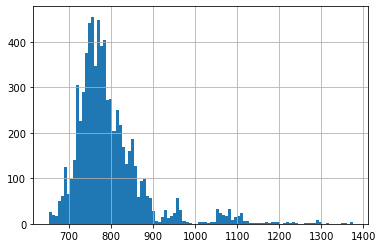

In [17]:
df_cleaned.elev.hist(bins=100)
df_cleaned.elev.max()

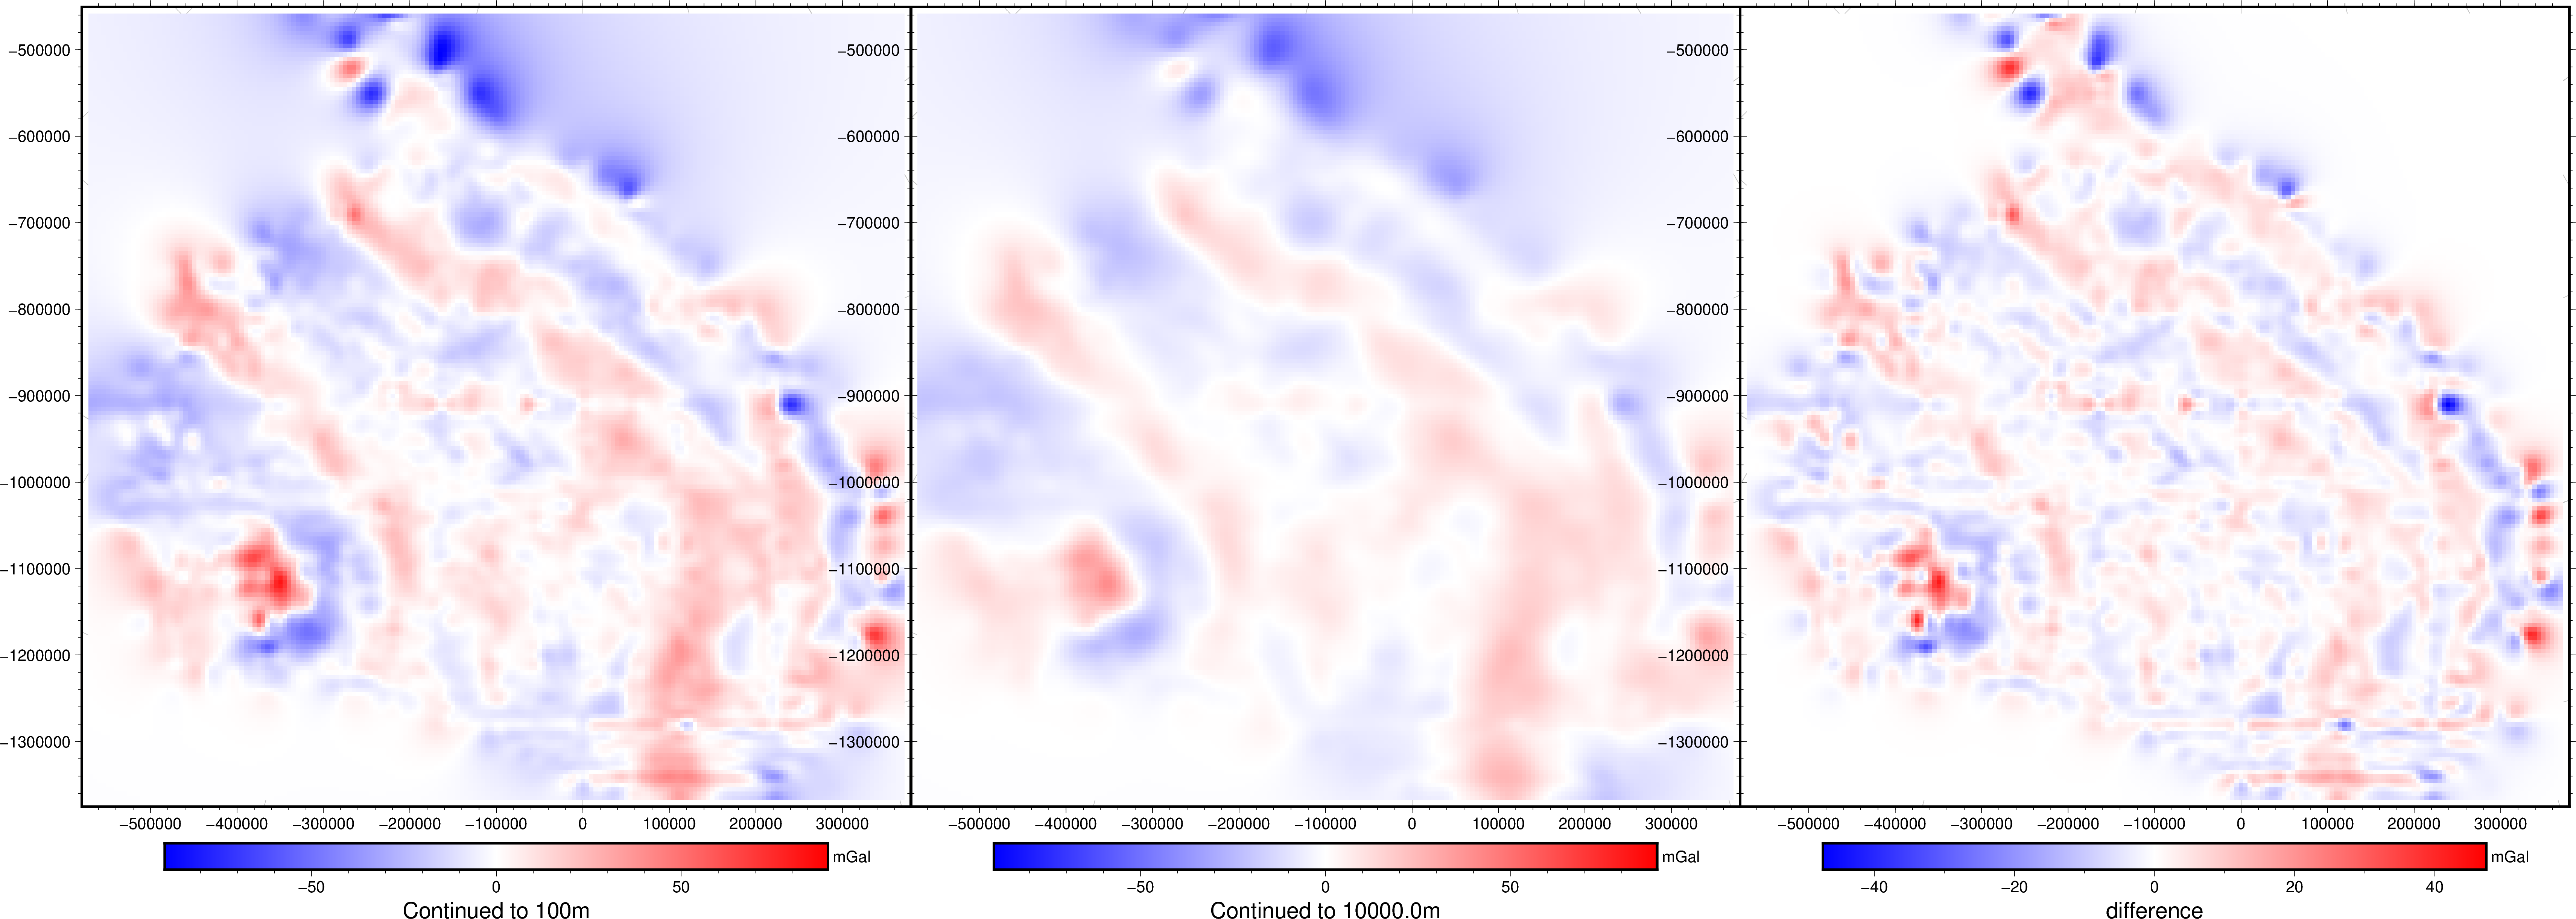

In [18]:
# Build the grid coordinates
region = vd.get_region(coordinates)

low=100
grid_coords_low = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=low)
high=10e3
grid_coords_high = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=high)

# Grid the gravity disturbances
grid_low = eqs_best.grid(grid_coords_low, data_names=["gravity_disturbance"])
grid_high = eqs_best.grid(grid_coords_high, data_names=["gravity_disturbance"])

diff = grid_low.gravity_disturbance - grid_high.gravity_disturbance
grid = diff

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y)) 
grid = grid_low.gravity_disturbance
maxabs = vd.maxabs(grid)
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=[f"x+lContinued to {low}m", "y+lmGal"])

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True)
grid = grid_high.gravity_disturbance 
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=[f"x+lContinued to {high}m", "y+lmGal"])

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
grid = diff
maxabs = vd.maxabs(grid)
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=["x+ldifference", "y+lmGal"])

fig.show()

# mask grid

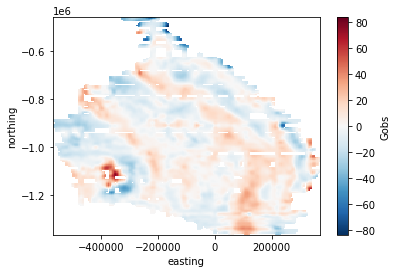

In [19]:
up_con_elev = 1e3
grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=up_con_elev)

# Grid the gravity disturbances
grid = eqs_best.grid(grid_coords, data_names=["Gobs"])
masked = vd.distance_mask((df_cleaned.x, df_cleaned.y), maxdist=10e3, grid=grid)
masked['height']=masked.upward
masked.Gobs.plot()

# save as netcdf

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Cartesian grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -569306.933744 x_max: 369269.342582 x_inc: 4992.42700173 name: x n_columns: 189
: y_min: -1365285.60916 y_max: -460457.076 y_inc: 4999.0526694 name: y n_rows: 182
: v_min: 1000 v_max: 1000 name: z
: scale_factor: 1 add_offset: 0
: format: classic



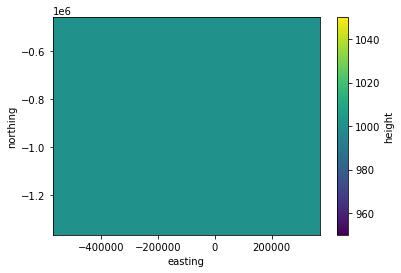

In [20]:
masked.height.plot()
print(pygmt.grdinfo(masked.height))

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Cartesian grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -569306.933744 x_max: 369269.342582 x_inc: 4992.42700173 name: x n_columns: 189
: y_min: -1365285.60916 y_max: -460457.076 y_inc: 4999.0526694 name: y n_rows: 182
: v_min: -83.5841751099 v_max: 76.3608627319 name: z
: scale_factor: 1 add_offset: 0
: format: classic



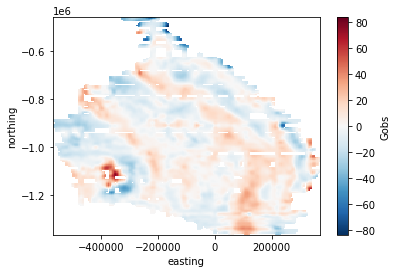

In [21]:
masked.Gobs.plot()
print(pygmt.grdinfo(masked.Gobs))

In [22]:
# grid = xr.Dataset()
pygmt.grdsample(
            grid=masked.height,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_elev.nc') 
pygmt.grdsample(
            grid=masked.Gobs,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_Gobs.nc') 
# grid.to_netcdf('gravity_data/rosetta_eq_source_up_continued_gridline.nc')

print(pygmt.grdinfo('gravity_data/rosetta_eq_source_up_continued_elev.nc'))

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


gravity_data/rosetta_eq_source_up_continued_elev.nc: Title: z
gravity_data/rosetta_eq_source_up_continued_elev.nc: Command: grdsample @GMTAPI@-S-I-G-M-G-N-000000 -Ggravity_data/rosetta_eq_source_up_continued_elev.nc -I5000+e -R-580000/420000/-1420000/-420000 -rp
gravity_data/rosetta_eq_source_up_continued_elev.nc: Remark: 
gravity_data/rosetta_eq_source_up_continued_elev.nc: Pixel node registration used [Cartesian grid]
gravity_data/rosetta_eq_source_up_continued_elev.nc: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
gravity_data/rosetta_eq_source_up_continued_elev.nc: x_min: -565000 x_max: 365000 x_inc: 5000 name: x n_columns: 186
gravity_data/rosetta_eq_source_up_continued_elev.nc: y_min: -1365000 y_max: -465000 y_inc: 5000 name: y n_rows: 180
gravity_data/rosetta_eq_source_up_continued_elev.nc: v_min: 1000 v_max: 1000 name: z
gravity_data/rosetta_eq_source_up_continued_elev.nc: scale_factor: 1 add_offset: 0
gravity_data/rosetta_eq_source_up_continued_elev.nc: forma

In [23]:
up_con_elev=1e3
grav = xr.load_dataarray('gravity_data/rosetta_eq_source_up_continued_Gobs.nc')
df = vd.grid_to_table(grav)
df.rename(columns={'z':'Gobs'}, inplace=True)

# elev = xr.load_dataarray('gravity_data/rosetta_eq_source_up_continued_elev.nc')
# df1 = vd.grid_to_table(elev)

df['z'] = up_con_elev
df.dropna(inplace=True)
df = df[['x','y','Gobs','z']]
df.to_csv('gravity_data/rosetta_eq_source_up_continued.csv', index=False)
df.describe()


x             y          Gobs        z
count   19666.000000  1.966600e+04  19666.000000  19666.0
mean   -93661.903793 -9.902100e+05     -0.248083   1000.0
std    223211.973413  1.971037e+05     13.005807      0.0
min   -562500.000000 -1.362500e+06    -83.122131   1000.0
25%   -262500.000000 -1.147500e+06     -7.901796   1000.0
50%    -92500.000000 -1.002500e+06     -0.095627   1000.0
75%     82500.000000 -8.475000e+05      7.546713   1000.0
max    362500.000000 -4.675000e+05     75.122253   1000.0

In [24]:
df=pd.read_csv('gravity_data/rosetta_eq_source_up_continued.csv', index_col=False)
df

x          y       Gobs       z
0       -2500.0 -1362500.0 -13.700118  1000.0
1        2500.0 -1362500.0 -14.224596  1000.0
2       17500.0 -1362500.0  -8.105549  1000.0
3       22500.0 -1362500.0  -9.038119  1000.0
4       27500.0 -1362500.0 -11.456600  1000.0
...         ...        ...        ...     ...
19661 -217500.0  -467500.0 -15.469933  1000.0
19662 -212500.0  -467500.0 -13.597374  1000.0
19663 -207500.0  -467500.0 -13.328206  1000.0
19664 -202500.0  -467500.0 -12.510348  1000.0
19665 -197500.0  -467500.0 -13.062867  1000.0

[19666 rows x 4 columns]

In [36]:
df['Gobs'] -= df.Gobs.mean()
df.describe()

x             y          Gobs        z
count   19666.000000  1.966600e+04  1.966600e+04  19666.0
mean   -93661.903793 -9.902100e+05 -3.699765e-16   1000.0
std    223211.973413  1.971037e+05  1.300581e+01      0.0
min   -562500.000000 -1.362500e+06 -8.287405e+01   1000.0
25%   -262500.000000 -1.147500e+06 -7.653712e+00   1000.0
50%    -92500.000000 -1.002500e+06  1.524566e-01   1000.0
75%     82500.000000 -8.475000e+05  7.794796e+00   1000.0
max    362500.000000 -4.675000e+05  7.537033e+01   1000.0

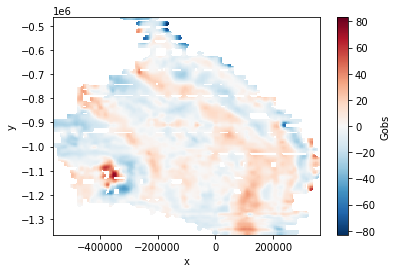

In [41]:
df.set_index(['y','x']).to_xarray().Gobs.plot()

## block reduce
to avoid aliasing along flight lines

gmtset [WARNING]: Representation of font type not recognized. Using default.


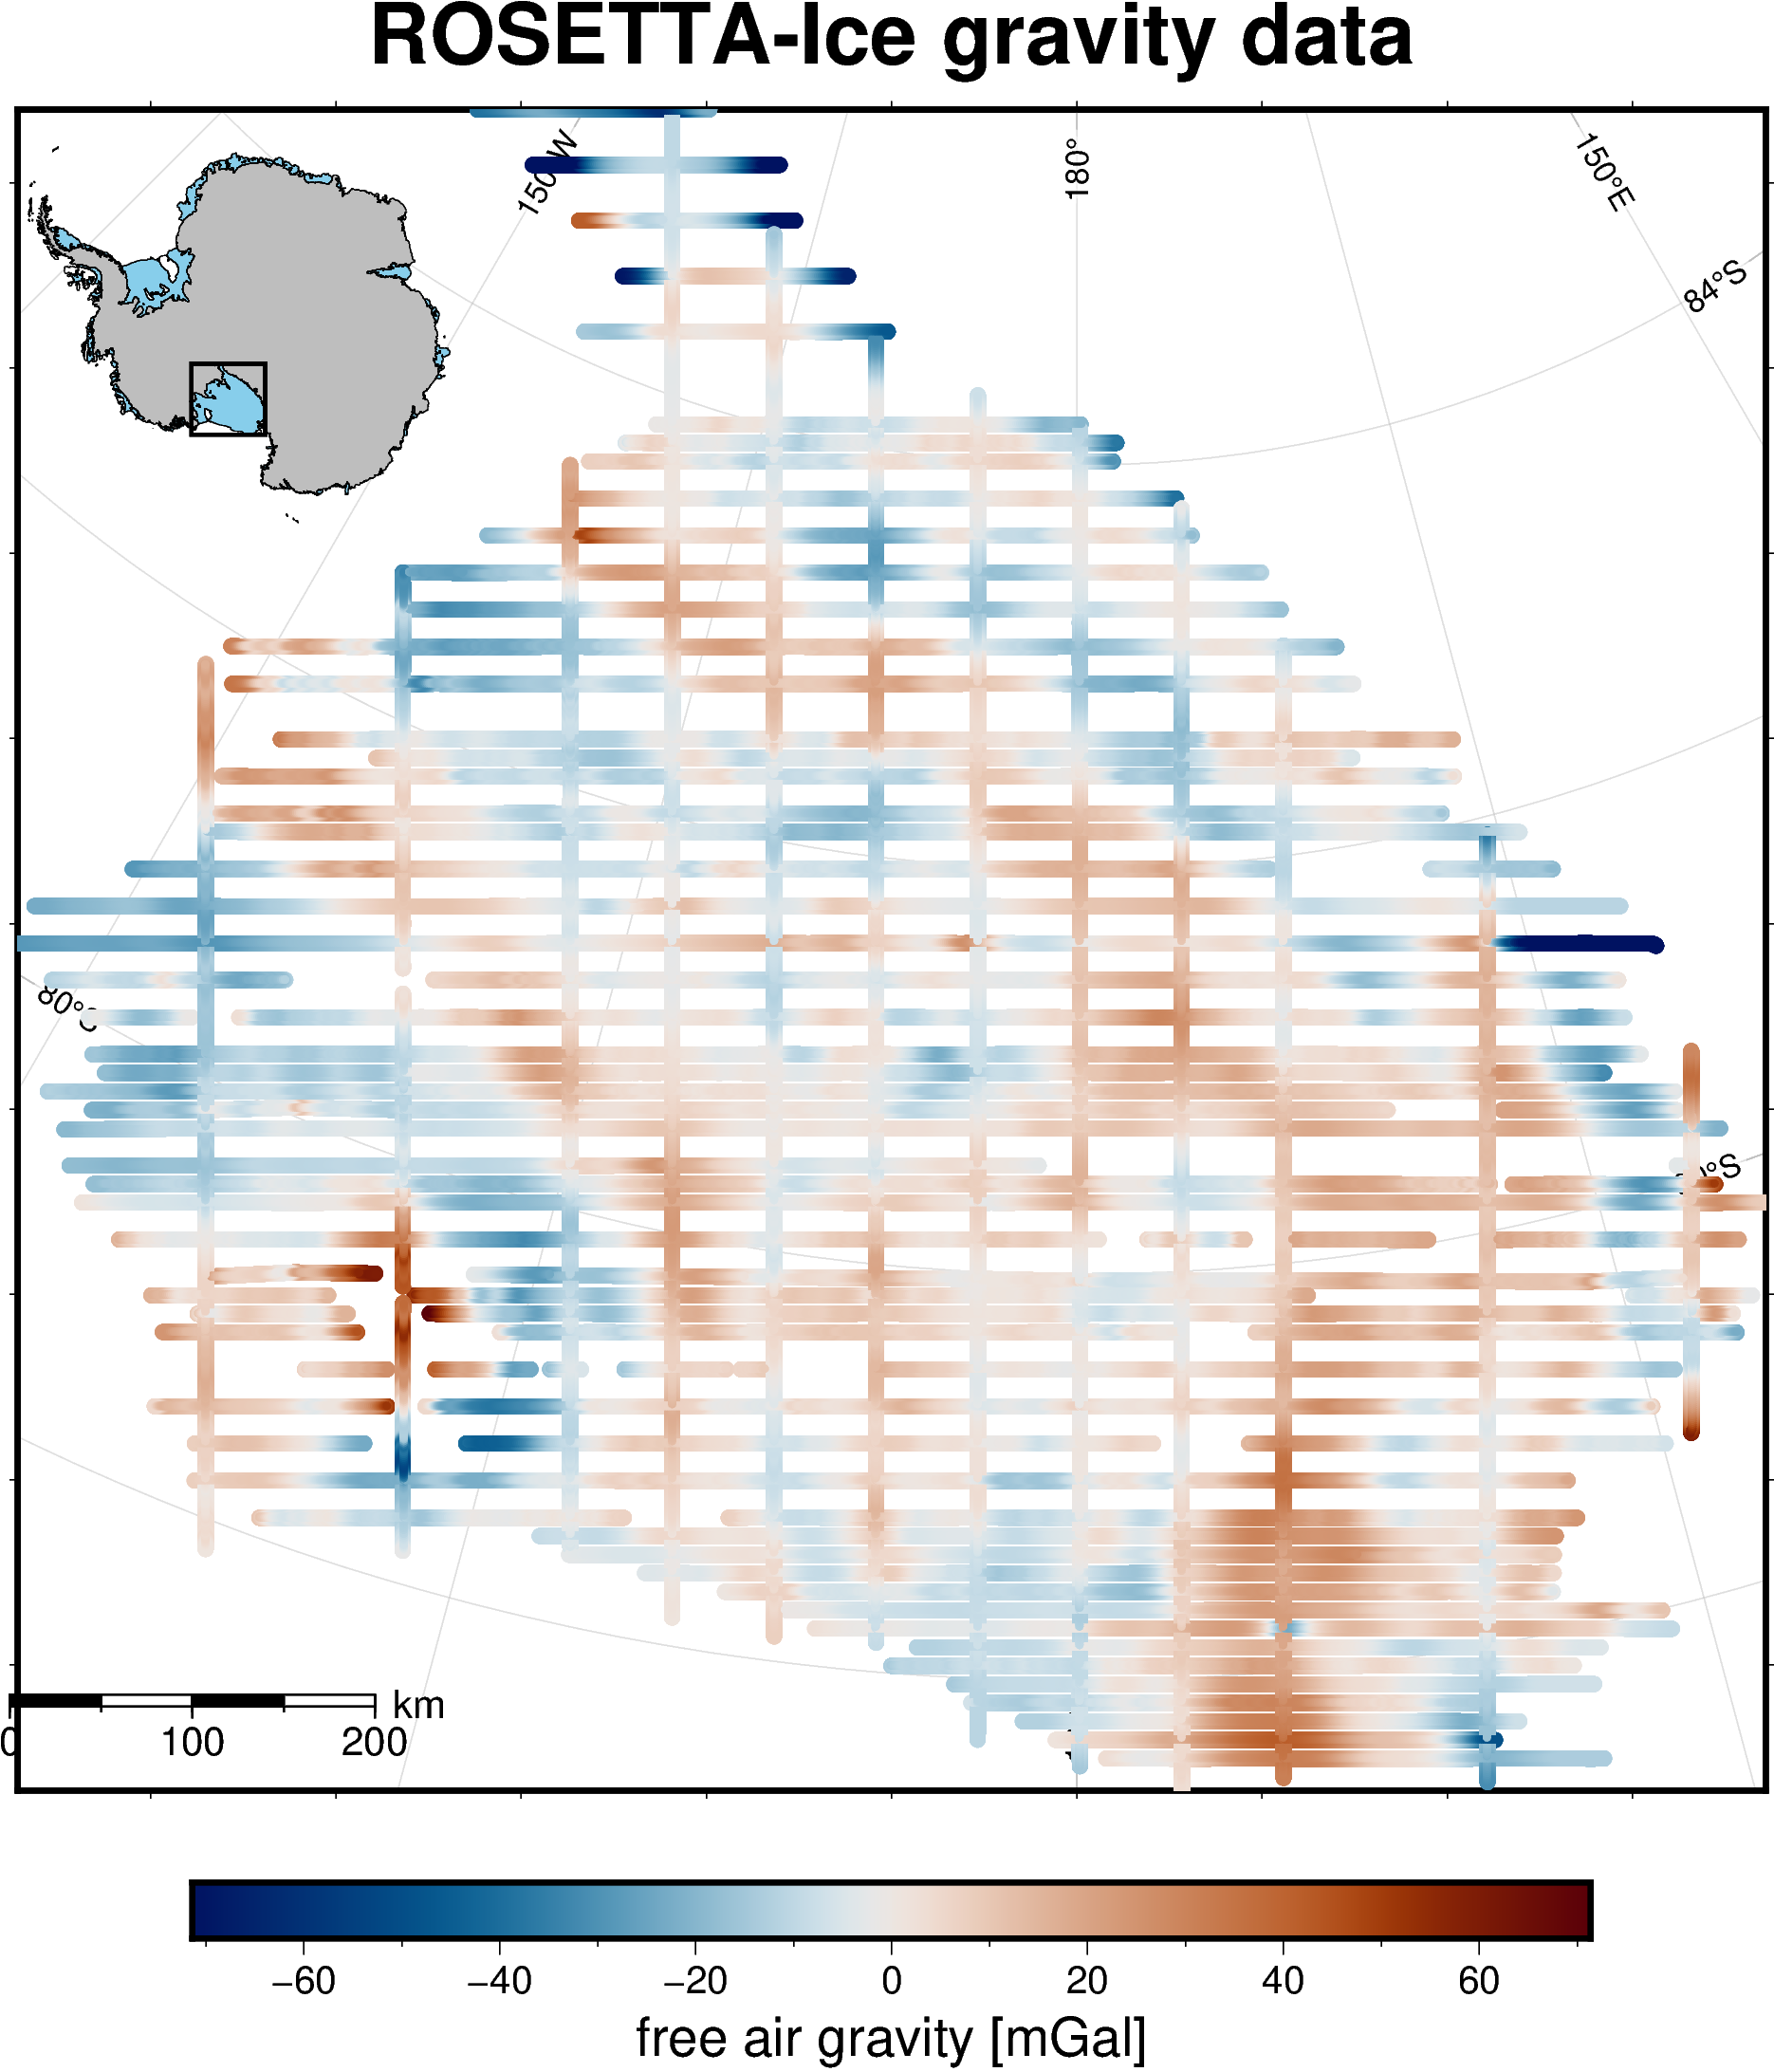

In [4]:
# set up parameters for a block reduction
reducer = vd.BlockReduce(
    # reduction=np.mean, 
    reduction=np.median, 
    spacing=1e3, 
    center_coordinates=True, # get average coordinate, not the center
    )

# get the mean/median gravity anomaly and flight elevation within each block
coordinates, data = reducer.filter(
    coordinates=(rosetta.x, rosetta.y), data=(rosetta.FAG_levelled, rosetta.Height))
# put results into dataframe
df = pd.DataFrame(data={'x': coordinates[0], 'y':coordinates[1], 'FAG_levelled':data[0], 'elev':data[1]})

# plot results 
fig = maps.basemap(
    region, 
    scale_position="n.2/.05",
    title="ROSETTA-Ice gravity data",
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df.FAG_levelled)*.25
pygmt.makecpt(cmap="curl", series=[-maxabs,maxabs])

# plot un-blocked data
fig.plot(x=rosetta.x, 
         y=rosetta.y, 
         color=rosetta.FAG_levelled,
         style='c4p',
         cmap=True)

#plot blocked data
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FAG_levelled,
         style='c2p',
         cmap=True)

fig.colorbar(frame='af+l"free air gravity [mGal]"')

fig.show()

## remove outliers

                   x             y  FAG_levelled         elev       zscore
count    7185.000000  7.185000e+03   7185.000000  7185.000000  7185.000000
mean   -85130.686232 -1.000598e+06     -0.174171   794.774991     0.663194
std    216707.838680  1.982769e+05     14.977596    86.214410     0.748500
min   -569306.933744 -1.365286e+06   -285.495163   651.087333     0.000181
25%   -244809.099852 -1.160504e+06     -7.500035   745.215020     0.229606
50%    -80040.915334 -1.010416e+06      0.199235   775.992293     0.509822
75%     84696.668212 -8.504525e+05      7.868218   820.331627     0.903796
max    369269.342582 -4.604571e+05     72.741864  1374.933457    19.051178


<AxesSubplot:>

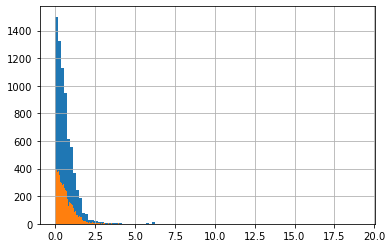

In [5]:
df['zscore']=np.abs(stats.zscore(df.FAG_levelled))
df.sort_values(by='zscore', ascending=False, inplace=True)
df.zscore.hist(bins=100)
print(df.describe())
# dropped base on z-score
df_cleaned=df[df.zscore < 5].copy()
df_outliers=df[df.zscore >= 5].copy()

# reset gravity at 0
df_cleaned['FAG_levelled'] -= df_cleaned.FAG_levelled.mean() 
df_cleaned.zscore.hist(bins=100)

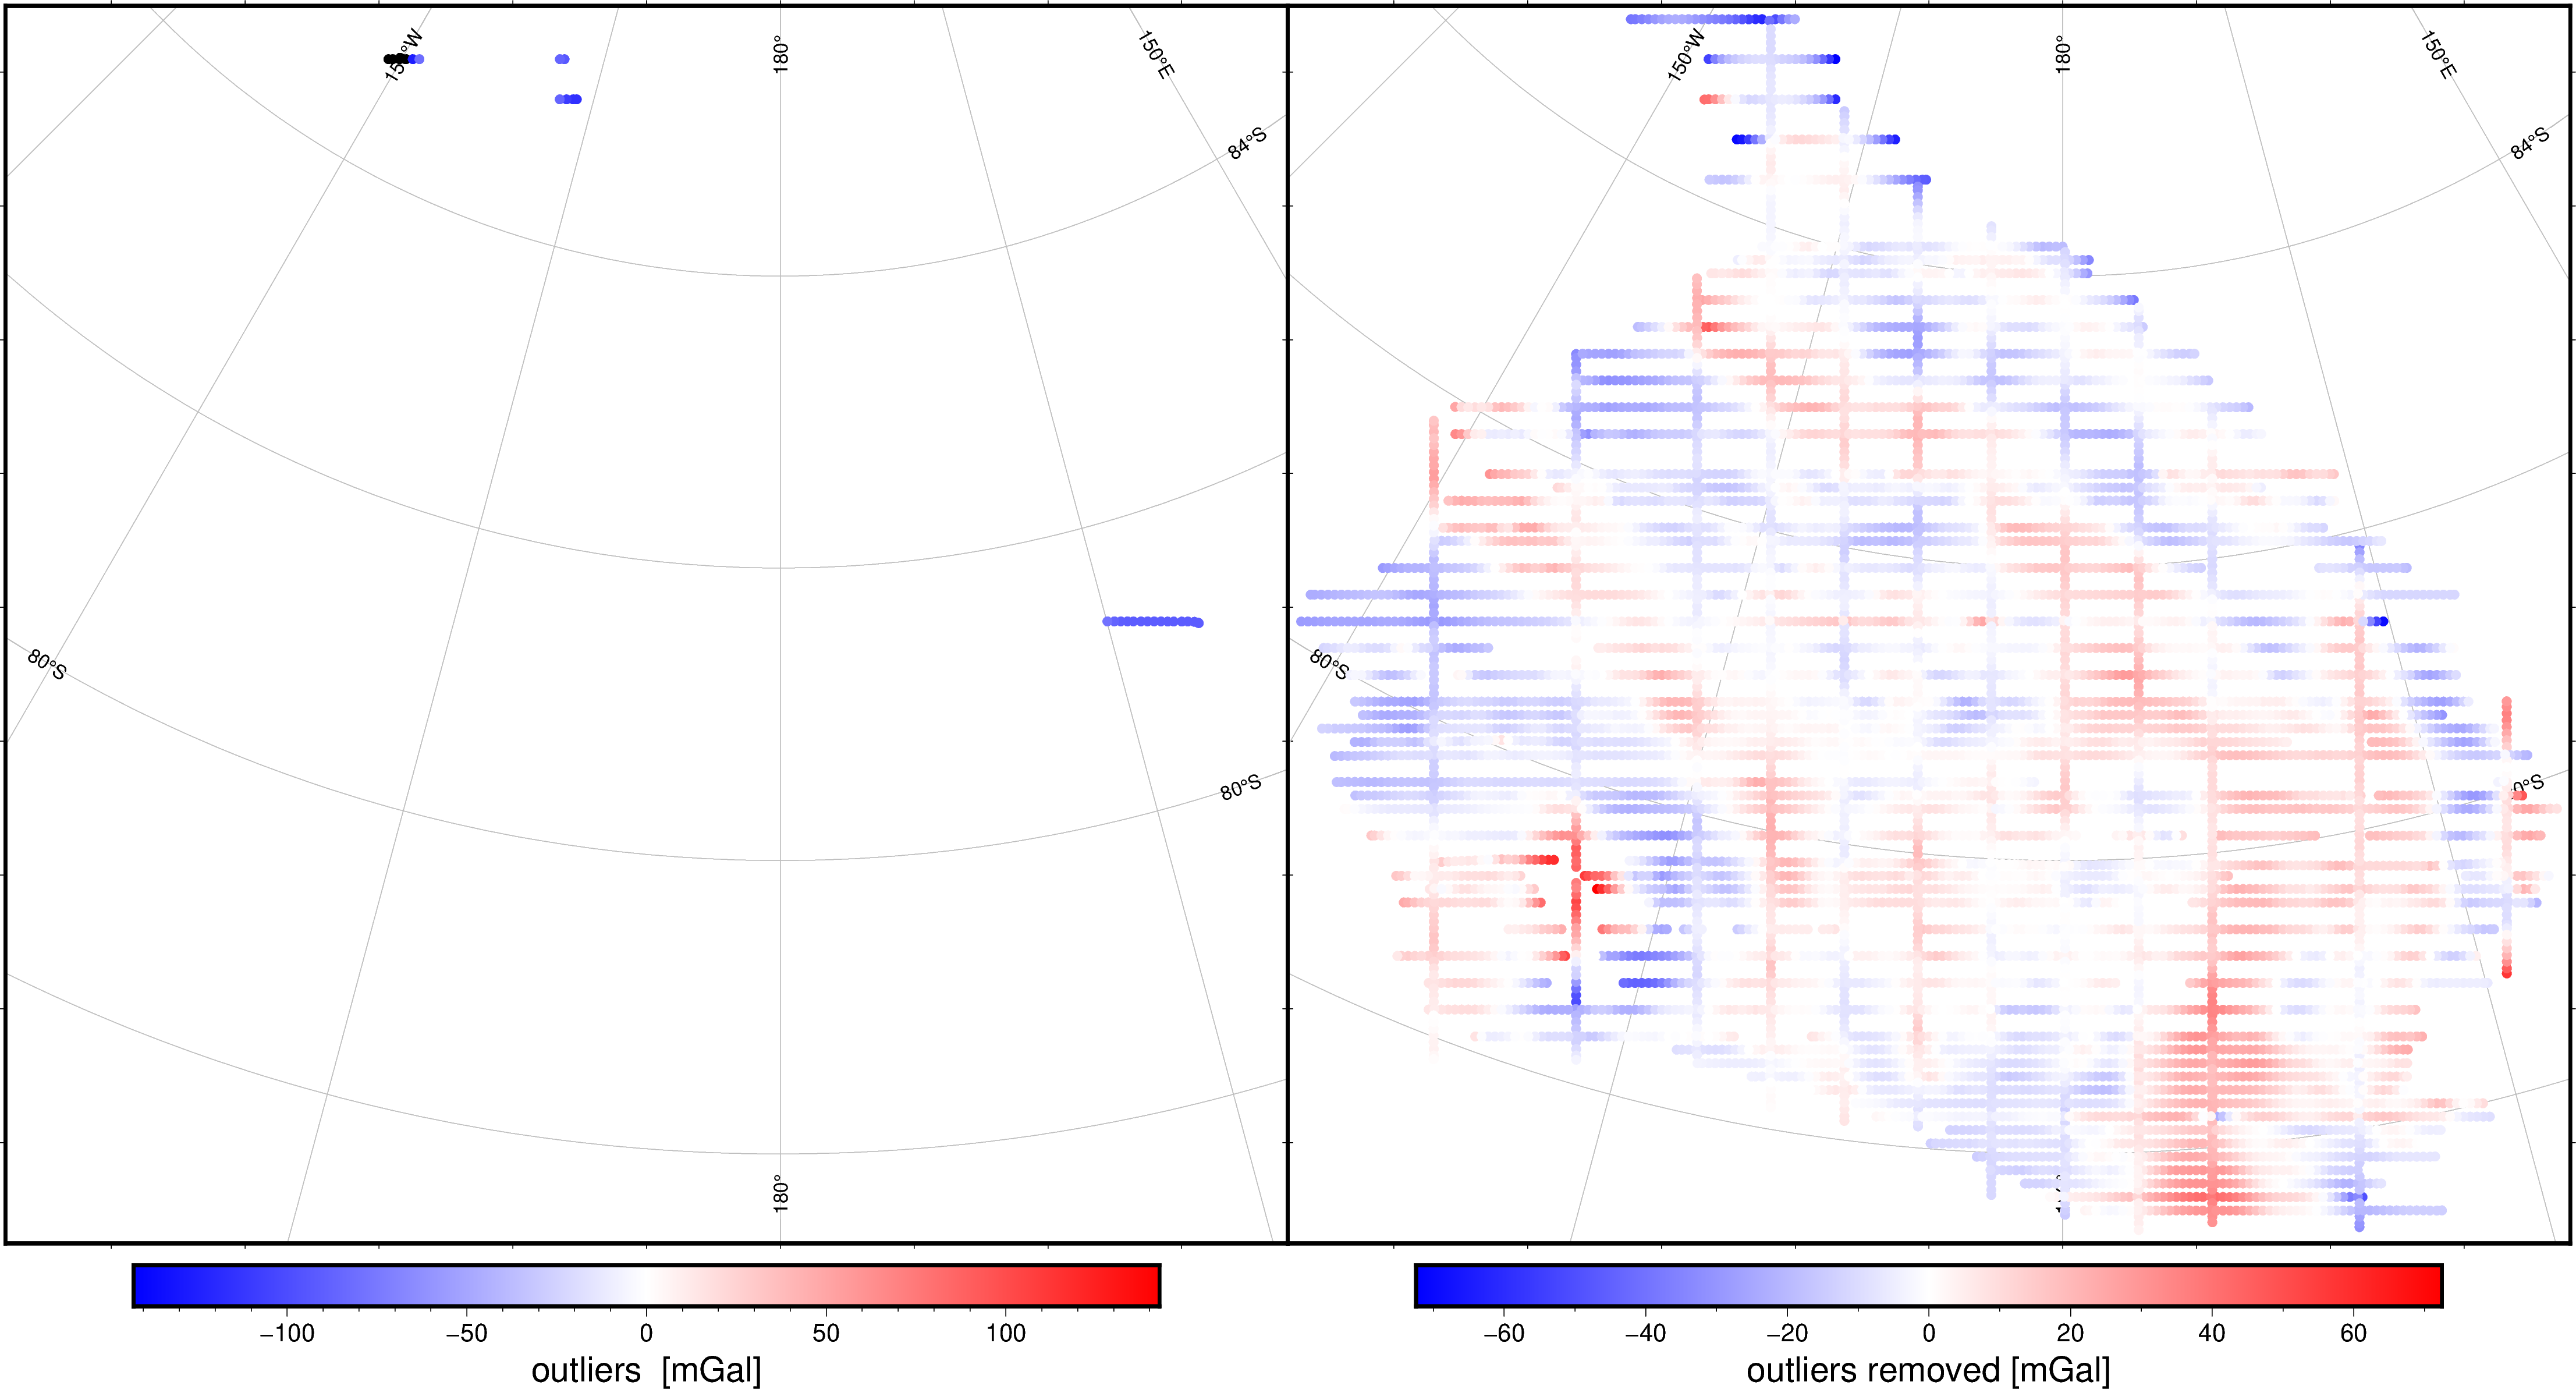

In [6]:
start_fig(data_region=True, coordinates=(df.x, df.y))
maxabs = vd.maxabs(df_outliers.FAG_levelled)*.5
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])
fig.plot(x=df_outliers.x, 
         y=df_outliers.y, 
         color=df_outliers.FAG_levelled,
         style='c4p',
         cmap=True)
fig.colorbar(frame='af+l"outliers  [mGal]"')

start_fig(data_region=True, coordinates=(df.x, df.y), subplots=True)

maxabs = vd.maxabs(df_cleaned.FAG_levelled)
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c4p',
         cmap=True)
fig.colorbar(frame='af+l"outliers removed [mGal]"')
fig.show()